In [1]:
import importlib
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

from ecpaper_utils import linfit_utils as linfit
from ecpaper_utils import bootstrap_utils as boot

importlib.reload(linfit)
importlib.reload(boot)

<module 'ecpaper_utils.bootstrap_utils' from '/home/islas/python/ecpaper2020/ecpaper_utils/bootstrap_utils.py'>

Read in CMIP jet latitudes, global mean tas and uncertainty estimates from the MMLEA's

In [2]:
datapath="/project/cas/islas/python/ecpaper2020/DATASORT/SHJET/DATA/"
cmip5jlats = datapath+"jlatcmip5.nc"
cmip6jlats = datapath+"jlatcmip6.nc"
cmip5gmt = datapath+"globalmeantascmip5.nc"
cmip6gmt = datapath+"globalmeantascmip6.nc"
cmip5errors = "../ERRORCALC/JLAT/DATA/errors_cmip5.nc"
cmip6errors = "../ERRORCALC/JLAT/DATA/errors_cmip6.nc"
errors1mem = "../ERRORCALC/JLAT/DATA/errors_1mem.nc"

In [3]:
jlat5 = xr.open_dataset(cmip5jlats) ; jlat6 = xr.open_dataset(cmip6jlats)
gmt5 = xr.open_dataset(cmip5gmt) ; gmt6 = xr.open_dataset(cmip6gmt)
error5 = xr.open_dataset(cmip5errors) ; error6 = xr.open_dataset(cmip6errors) ; error1mem = xr.open_dataset(errors1mem)

CMIP5 variance decomposition and other calcs

In [4]:
# ensemble mean calculations for CMIP5

# jet shift after regressing out the change in global mean tas
a, b = linfit.linfit_xy( gmt5['tasemf'] - gmt5['tasemp'], jlat5['jlatemf']-jlat5['jlatemp'], error5['sigy'])
jlatdif_nots_em = (jlat5['jlatemf']-jlat5['jlatemp'])  - (a + b*( gmt5['tasemf'] - gmt5['tasemp']))

# correlation between phi_o and delta phi and uncertainty range
r5 = xr.corr(jlat5['jlatemp'],jlat5['jlatemf']-jlat5['jlatemp'])
minr5, maxr5 = boot.boot_corr_ci(jlat5['jlatemp'],jlat5['jlatemf']-jlat5['jlatemp'],95)

# and after first regressing out global mean tas
r5nots = xr.corr(jlat5['jlatemp'], jlatdif_nots_em)
minr5nots, maxr5nots = boot.boot_corr_ci(jlat5['jlatemp'], jlatdif_nots_em, 95)

# ensemble mean correlation between jet shift and global mean tas change
rdphidt5 = xr.corr( jlat5['jlatemf']-jlat5['jlatemp'], gmt5['tasemf']-gmt5['tasemp'])
minrdphidt5, maxrdphidt5 = boot.boot_corr_ci(jlat5['jlatemf']-jlat5['jlatemp'], gmt5['tasemf']-gmt5['tasemp'], 95)

# ensemble mean variance of phi_o
varphio5 = np.var(jlat5['jlatemp'])

#ols regression coefficients and confidence interval
aols5em, bols5em = linfit.linfit_xy(jlat5['jlatemp'], jlat5['jlatemf'] - jlat5['jlatemp'], error5['sigy'])
aolsrange5, bolsrange5 = boot.boot_regcoef_ci(jlat5['jlatemp'], jlat5['jlatemf'] - jlat5['jlatemp'], 95, sigy=error5['sigy'])

# tls regression coefficients and confidence interval
atls5em, btls5em = linfit.tls(jlat5['jlatemp'], jlat5['jlatemf'] - jlat5['jlatemp'], error5['sigx'],error5['sigy'])
atlsrange5, btlsrange5 = boot.boot_regcoef_ci(jlat5['jlatemp'], jlat5['jlatemf'] - jlat5['jlatemp'], 95, sigx=error5['sigx'],sigy=error5['sigy'])

# bhm coefficients and confidence interval
abhmall5, bbhmall5, del2all5, muxall5, delx2all5 = linfit.bhm(jlat5['jlatemp'], (jlat5['jlatemf']-jlat5['jlatemp']), 
                                                              error5['sigx'], error5['sigy'], error5['rxy'], iseed=3)
abhm5em = np.mean(abhmall5)
bbhm5em = np.mean(bbhmall5)
abhmmin = np.percentile(abhmall5,2.5) ; abhmmax = np.percentile(abhmall5,97.5)
bbhmmin = np.percentile(bbhmall5,2.5) ; bbhmmax = np.percentile(bbhmall5,97.5)
abhmrange5=[abhmmin,abhmmax]
bbhmrange5=[bbhmmin,bbhmmax]

In [5]:
# single member calculations for CMIP5

# expand 1 member error estimates to array of size nmodels
sigx1mem = np.repeat(np.array(error1mem['sigx_1mem']), jlat5['jlat1memp'].size)
sigy1mem = np.repeat(np.array(error1mem['sigy_1mem']), jlat5['jlat1memp'].size)
rxy1mem = np.repeat(np.array(error1mem['rxy_1mem']), jlat5['jlat1memp'].size)

# regress out global mean tas change from jet shift (1 member and then all ensemble mean)
a, b = linfit.linfit_xy( gmt5['tas1memf'] - gmt5['tas1memp'], jlat5['jlat1memf']-jlat5['jlat1memp'], sigy1mem)
jlatdif_nots = (jlat5['jlat1memf']-jlat5['jlat1memp'])  - (a + b*( gmt5['tas1memf'] - gmt5['tas1memp'])) 
var_nots = np.var(jlatdif_nots)

# single member variance
var5=np.var(jlat5['jlat1memf']-jlat5['jlat1memp'])

# single member variance explained by global mean tas change
vartsexplain5 = var5 - var_nots

# ols regression variance decomposition
aols5, bols5 = linfit.linfit_xy(jlat5['jlat1memp'], jlat5['jlat1memf']-jlat5['jlat1memp'], sigy1mem)
jlatdif_ec = aols5 + bols5*jlat5['jlat1memp']
res = (jlat5['jlat1memf'] - jlat5['jlat1memp']) - jlatdif_ec[:]

varres5_ols = np.var(res)
var5ec_ols = var5 - varres5_ols
variv5_ols = (bols5**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta5_ols = var5 - (var5ec_ols + variv5_ols)

cmip5olsdecomp=[var5ec_ols, variv5_ols, vardelta5_ols]

# tls regression variance decomposition
atls5, btls5 = linfit.tls(jlat5['jlat1memp'], jlat5['jlat1memf']-jlat5['jlat1memp'], sigx1mem, sigy1mem)
jlatdif_ec = atls5 + btls5*jlat5['jlat1memp']
res = (jlat5['jlat1memf'] - jlat5['jlat1memp']) - jlatdif_ec[:]

varres5_tls = np.var(res)
var5ec_tls = var5 - varres5_tls
variv5_tls = (btls5**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta5_tls = var5 - (var5ec_tls + variv5_tls)

cmip5tlsdecomp=[var5ec_tls, variv5_tls, vardelta5_tls]

#blr regression
abhmall5, bbhmall5, del2all5, muxall5, delx2all5 = linfit.bhm(jlat5['jlat1memp'], (jlat5['jlat1memf']-jlat5['jlat1memp']), 
                                                              sigx1mem, sigy1mem, rxy1mem, iseed=3)
abhm5 = np.mean(abhmall5) ; bbhm5 = np.mean(bbhmall5)

var5ec_bhm = np.mean((bbhmall5[:]**2.)*delx2all5[:])
vardelta5_bhm=np.mean(del2all5[:])
variv5_bhm = np.mean(sigx1mem*(1. - rxy1mem**2.))

cmip5bhmdecomp=[var5ec_bhm, variv5_bhm, vardelta5_bhm]

CMIP6 variance decomposition and other calcs

In [6]:
# ensemble mean calculations for CMIP6

# jet shift after regressing out the change in global mean tas
a, b = linfit.linfit_xy( gmt6['tasemf'] - gmt6['tasemp'], jlat6['jlatemf']-jlat6['jlatemp'], error6['sigy'])
jlatdif_nots_em = (jlat6['jlatemf']-jlat6['jlatemp'])  - (a + b*( gmt6['tasemf'] - gmt6['tasemp']))

# correlation between phi_o and delta phi and uncertainty range
r6 = xr.corr(jlat6['jlatemp'],jlat6['jlatemf']-jlat6['jlatemp'])
minr6, maxr6 = boot.boot_corr_ci(jlat6['jlatemp'],jlat6['jlatemf']-jlat6['jlatemp'],95)

# and after first regressing out global mean tas
r6nots = xr.corr(jlat6['jlatemp'], jlatdif_nots_em)
minr6nots, maxr6nots = boot.boot_corr_ci(jlat6['jlatemp'], jlatdif_nots_em, 95)

# ensemble mean correlation between jet shift and global mean tas change
rdphidt6 = xr.corr( jlat6['jlatemf']-jlat6['jlatemp'], gmt6['tasemf']-gmt6['tasemp'])
minrdphidt6, maxrdphidt6 = boot.boot_corr_ci(jlat6['jlatemf']-jlat6['jlatemp'], gmt6['tasemf']-gmt6['tasemp'], 95)

# ensemble mean variance of phi_o
varphio6 = np.var(jlat6['jlatemp'])

#ols regression coefficients and confidence interval
aols6em, bols6em = linfit.linfit_xy(jlat6['jlatemp'], jlat6['jlatemf'] - jlat6['jlatemp'], error6['sigy'])
aolsrange6, bolsrange6 = boot.boot_regcoef_ci(jlat6['jlatemp'], jlat6['jlatemf'] - jlat6['jlatemp'], 95, sigy=error6['sigy'])

# tls regression coefficients and confidence interval
atls6em, btls6em = linfit.tls(jlat6['jlatemp'], jlat6['jlatemf'] - jlat6['jlatemp'], error6['sigx'],error6['sigy'])
atlsrange6, btlsrange6 = boot.boot_regcoef_ci(jlat6['jlatemp'], jlat6['jlatemf'] - jlat6['jlatemp'], 95, sigx=error6['sigx'],sigy=error6['sigy'])

# bhm coefficients and confidence interval
abhmall6, bbhmall6, del2all6, muxall6, delx2all6 = linfit.bhm(jlat6['jlatemp'], (jlat6['jlatemf']-jlat6['jlatemp']), 
                                                              error6['sigx'], error6['sigy'], error6['rxy'], iseed=3)
abhm6em = np.mean(abhmall6)
bbhm6em = np.mean(bbhmall6)
abhmmin = np.percentile(abhmall6,2.5) ; abhmmax = np.percentile(abhmall6,97.5)
bbhmmin = np.percentile(bbhmall6,2.5) ; bbhmmax = np.percentile(bbhmall6,97.5)
abhmrange6=[abhmmin,abhmmax]
bbhmrange6=[bbhmmin,bbhmmax]

In [79]:
# single member calculations for CMIP5

# expand 1 member error estimates to array of size nmodels
sigx1mem = np.repeat(np.array(error1mem['sigx_1mem']), jlat6['jlat1memp'].size)
sigy1mem = np.repeat(np.array(error1mem['sigy_1mem']), jlat6['jlat1memp'].size)
rxy1mem = np.repeat(np.array(error1mem['rxy_1mem']), jlat6['jlat1memp'].size)

# regress out global mean tas change from jet shift (1 member and then all ensemble mean)
a, b = linfit.linfit_xy( gmt6['tas1memf'] - gmt6['tas1memp'], jlat6['jlat1memf']-jlat6['jlat1memp'], sigy1mem)
jlatdif_nots = (jlat6['jlat1memf']-jlat6['jlat1memp'])  - (a + b*( gmt6['tas1memf'] - gmt6['tas1memp'])) 
var_nots = np.var(jlatdif_nots)

# single member variance
var6=np.var(jlat6['jlat1memf']-jlat6['jlat1memp'])

# single member variance explained by global mean tas change
vartsexplain6 = var6 - var_nots

# ols regression variance decomposition
aols6, bols6 = linfit.linfit_xy(jlat6['jlat1memp'], jlat6['jlat1memf']-jlat6['jlat1memp'], sigy1mem)
jlatdif_ec = aols6 + bols6*jlat6['jlat1memp']
res = (jlat6['jlat1memf'] - jlat6['jlat1memp']) - jlatdif_ec[:]

varres6_ols = np.var(res)
var6ec_ols = var6 - varres6_ols
variv6_ols = (bols6**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta6_ols = var6 - (var6ec_ols + variv6_ols)

cmip6olsdecomp=[var6ec_ols, variv6_ols, vardelta6_ols]

# tls regression variance decomposition
atls6, btls6 = linfit.tls(jlat6['jlat1memp'], jlat6['jlat1memf']-jlat6['jlat1memp'], sigx1mem, sigy1mem)
jlatdif_ec = atls6 + btls6*jlat6['jlat1memp']
res = (jlat6['jlat1memf'] - jlat6['jlat1memp']) - jlatdif_ec[:]

varres6_tls = np.var(res)
var6ec_tls = var6 - varres6_tls
variv6_tls = (btls6**2. * sigx1mem[0]**2.) + sigy1mem[0]**2.
vardelta6_tls = var6 - (var6ec_tls + variv6_tls)

cmip6tlsdecomp=[var6ec_tls, variv6_tls, vardelta6_tls]

#blr regression
abhmall6, bbhmall6, del2all6, muxall6, delx2all6 = linfit.bhm(jlat6['jlat1memp'], (jlat6['jlat1memf']-jlat6['jlat1memp']), 
                                                              sigx1mem, sigy1mem, rxy1mem, iseed=3)
abhm6 = np.mean(abhmall6) ; bbhm6 = np.mean(bbhmall6)

var6ec_bhm = np.mean((bbhmall6[:]**2.)*delx2all6[:])
vardelta6_bhm=np.mean(del2all6[:])
variv6_bhm = np.mean(sigx1mem*(1. - rxy1mem**2.))

cmip6bhmdecomp=[var6ec_bhm, variv6_bhm, vardelta6_bhm]

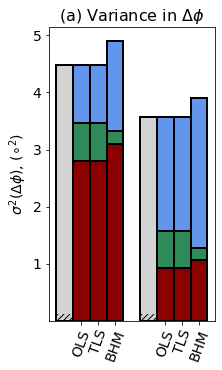

In [178]:
#fig, axs = plt.subplots(nrows = 3, ncols = 2)
fig = plt.figure()
w = 7 ; h = 24
fig.set_size_inches(w,h)
div = np.array([w, h, w, h])
ax1 = fig.add_axes(np.array([0.05,0.8,0.33,0.17]))
#ax3 = fig.add_axes(np.array([0.05,0.6,0.07,0.15]))

# -------------Variance decomposition, panel a -------------------
ax1.set_xticks([2.,3.,4.,7.,8.,9.])
ax1.set_xticklabels(['OLS','TLS','BHM','OLS','TLS','BHM'], rotation='70', fontsize=14)
ax1.set_yticks([1,2,3,4,5])
ax1.set_yticklabels([1,2,3,4,5], fontsize=14)
ax1.set_ylabel("$\sigma^{2}(\Delta \phi)$, $(\circ^{2})$", fontsize=14)
ax1.set_title("(a) Variance in $\Delta \phi$", fontsize=16)

ax1.bar(1., var5, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax1.bar(1., vartsexplain5, width=1, bottom=None, align='center', fill=False, hatch='////', linewidth=0)

decompcolors=["darkred","seagreen","cornflowerblue"]

bot=0
for i in range(0,3):
    ax1.bar(2., cmip5olsdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip5olsdecomp[i]

bot=0
for i in range(0,3):
    ax1.bar(3., cmip5tlsdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip5tlsdecomp[i]
    
bot=0
for i in range(0,3):
    ax1.bar(4., cmip5bhmdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip5bhmdecomp[i]   
    
ax1.bar(6, var6, width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax1.bar(6, vartsexplain6, width=1, bottom=None, align='center', fill=False, hatch='////', linewidth=0)

bot=0
for i in range(0,3):
    ax1.bar(7., cmip6olsdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip6olsdecomp[i]
    
bot=0
for i in range(0,3):
    ax1.bar(8., cmip6tlsdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip6tlsdecomp[i]  
    
bot=0
for i in range(0,3):
    ax1.bar(9., cmip6bhmdecomp[i], width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+cmip6bhmdecomp[i]  
    

In [179]:
# -------variance decomposition (%) panel b ----------------
ax2 = fig.add_axes(np.array([0.5,0.8,0.33,0.17]))
# -------------Variance decomposition, panel a -------------------
ax2.set_xticks([2.,3.,4.,7.,8.,9.])
ax2.set_xticklabels(['OLS','TLS','BHM','OLS','TLS','BHM'], rotation='70', fontsize=14)
ax2.set_yticks([0,20,40,60,80,100])
ax2.set_yticklabels(['0','20','40','60','80','100'], fontsize=14)
ax2.set_ylabel("Variance (%)", fontsize=14)
ax2.set_title("(b) % variance in $\Delta \phi$", fontsize=16)

ax2.bar(1., (var5/var5)*100., width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax2.bar(1., (vartsexplain5/var5)*100., width=1, bottom=None, align='center', fill=False, linewidth=0, hatch='////')

decompcolors=["darkred","seagreen","cornflowerblue"]

bot=0
for i in range(0,3):
    ax2.bar(2., (cmip5olsdecomp[i]/var5)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5olsdecomp[i]/var5)*100.

bot=0
for i in range(0,3):
    ax2.bar(3., (cmip5tlsdecomp[i]/var5)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5tlsdecomp[i]/var5)*100.
    
bot=0
for i in range(0,3):
    ax2.bar(4., (cmip5bhmdecomp[i]/np.sum(cmip5bhmdecomp))*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip5bhmdecomp[i]/np.sum(cmip5bhmdecomp))*100.   
    
ax2.bar(6, (var6/var6)*100., width=1, bottom=None, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax2.bar(6, (vartsexplain6/var6)*100., width=1, bottom=None, align='center', fill=False, linewidth=0, hatch='////')

bot=0
for i in range(0,3):
    ax2.bar(7., (cmip6olsdecomp[i]/var6)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6olsdecomp[i]/var6)*100.
    
bot=0
for i in range(0,3):
    ax2.bar(8., (cmip6tlsdecomp[i]/var6)*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6tlsdecomp[i]/var6)*100.  
    
bot=0
for i in range(0,3):
    ax2.bar(9., (cmip6bhmdecomp[i]/np.sum(cmip6bhmdecomp))*100., width=1, bottom=bot, align='center', color=decompcolors[i], edgecolor='black', linewidth=2)
    bot=bot+(cmip6bhmdecomp[i]/np.sum(cmip6bhmdecomp))*100.  


#fig.show()

In [180]:
legendparts=[Rectangle((0.95,0.95),5,3,facecolor='lightgray', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,linewidth=0,fill='None', facecolor='white', hatch='////'),
             Rectangle((0.95,0.95),5,3,facecolor='darkred',edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='seagreen',edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='cornflowerblue',edgecolor='black')]
legendlabels=['$\sigma^{2}(\Delta \phi)$','$\sigma^{2}_{\Delta T_{2m}}$','$\sigma^{2}_{EC}$','$\sigma^{2}_{IV}$','$\sigma^{2}_{\delta}$']
fig.legend(legendparts, legendlabels, bbox_to_anchor = (1.,0.94), ncol=1, frameon=False, fontsize='x-large', handlelength=1, handleheight=1, handletextpad=0.4)

In [181]:
ax3 = fig.add_axes(np.array([0.05,0.6,0.3,0.15]))

ax3.set_xlim(0,6)
ax3.set_xticks([1,2,4,5])
ax3.set_xticklabels(['CMIP5','CMIP6','CMIP5','CMIP6'], rotation='70', fontsize=14)
ax3.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2])
ax3.set_yticklabels(['-1','-0.8','-0.6','-0.4','-0.2','0','0.2'], fontsize=14)
ax3.set_ylabel('Correlation', fontsize=14)
ax3.set_title('(c) r($\phi_{o},\Delta \phi$)', fontsize=16)
ax3.set_ylim(-1,0.2)
ax3.set_xlim(0,6)

# CMIP5 correlation
ax3.bar(1,r5,width=1,bottom=0,align='center',color='lightgray',edgecolor='black',linewidth=2)
ax3.errorbar(1,r5,[[r5-minr5],[maxr5-r5]], color='black', linewidth=2, capsize=5, capthick=2.)

# CMIP6 correlation
ax3.bar(2,r6,width=1,bottom=0,align='center',color='lightgray',edgecolor='black',linewidth=2)
ax3.errorbar(2,r6,[[r6-minr6],[maxr6-r6]], color='black', linewidth=2, capsize=5, capthick=2.)

# CMIP5 correlation after regressing out tas
ax3.bar(4, r5nots, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax3.errorbar(4, r5nots, [[r5nots-minr5nots], [maxr5nots-r5nots]], color='black', linewidth=2, capsize=5, capthick=2)

# CMIP6 correlation after regressing out tas
ax3.bar(5, r6nots, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax3.errorbar(5, r6nots, [[r6nots-minr6nots], [maxr6nots-r6nots]], color='black', linewidth=2, capsize=5, capthick=2)


ax3.plot([0,6],[0,0], color='black')
ax3.plot([3,3],[-1,0.2], color='black')
ax3.text(4.5, 0.13,'without $\Delta T_{2m}$', horizontalalignment='center',verticalalignment='center',fontsize=11,color='black')
ax3.text(4.5, 0.06,'influence',horizontalalignment='center',verticalalignment='center',fontsize=12,color='black')

plt.show()

In [182]:
ax4 = fig.add_axes(np.array([0.48,0.6,0.17,0.15]))
ax4.set_xticks([1,2])
ax4.set_xticklabels(['CMIP5','CMIP6'], rotation=70, fontsize=14)
ax4.set_ylim(-0.6,0.6)
ax4.set_xlim(0,3)
ax4.plot([0,3],[0,0], color='black')
ax4.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax4.set_yticklabels(['-0.6','-0.4','-0.2','0','0.2','0.4','0.6'],fontsize=14)
ax4.set_ylabel("Correlation", fontsize=14)
ax4.set_title("(d) $r(\Delta T_{2m}, \Delta \phi)$", fontsize=16)

ax4.bar(1, rdphidt5, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax4.errorbar(1,rdphidt5,[[rdphidt5-minrdphidt5],[maxrdphidt5-rdphidt5]], color='black', linewidth=2, capsize=5, capthick=2.)

ax4.bar(2, rdphidt6, width=1, bottom=0, align='center', color='lightgray', edgecolor='black', linewidth=2)
ax4.errorbar(2,rdphidt6,[[rdphidt6-minrdphidt6],[maxrdphidt6-rdphidt6]], color='black', linewidth=2, capsize=5, capthick=2.)
#ax4.set_yticklabels(fontsize=14)

<ErrorbarContainer object of 3 artists>

In [183]:
ax5 = fig.add_axes(np.array([0.77,0.6,0.17,0.15]))

ax5.set_xlim(0,3)
ax5.set_ylim(0,23)
ax5.set_xticks([1,2])
ax5.set_xticklabels(['CMIP5', 'CMIP6'], rotation=70, fontsize=14)
ax5.set_yticks([0,4,8,12,16,20])
ax5.set_yticklabels(['0','4','8','12','16','20'], fontsize=14)
ax5.set_ylabel('Variance ($\circ^{2}$)', fontsize=14)
ax5.set_title('(e) $\sigma^{2}(\phi_{o})$', fontsize=16)

ax5.bar(1,varphio5, width=1, bottom=0, color='lightgray', edgecolor='black', linewidth=2)
ax5.bar(2,varphio6, width=1, bottom=0, color='lightgray', edgecolor='black', linewidth=2)

<BarContainer object of 1 artists>

In [184]:
ax6 = fig.add_axes(np.array([0.05,0.45,0.89,0.1]))
ax6.set_xlim(0,8)
ax6.set_ylim(-34,10)
ax6.set_yticks([-30,-25,-20,-15,-10,-5,0,5,10])
ax6.set_yticklabels(['-30','-25','-20','-15','-10','-5','0','5','10'], fontsize=14)
ax6.set_xticks([])
ax6.plot([0,9],[0,0],color='black')
ax6.plot([4,4],[-34,10],color='black')
ax6.set_ylabel('$\\alpha$ ($\circ$ N)', fontsize=14)
ax6.set_title('(f) $\\alpha$ parameter', fontsize=16)

ax6.bar(1,aols5em,bottom=0,width=1,color='saddlebrown', linewidth=2, edgecolor='black')
ax6.errorbar(1,aols5em,[[aols5em-aolsrange5[0]],[aolsrange5[1]-aols5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(2,atls5em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax6.errorbar(2,atls5em,[[atls5em-atlsrange5[0]],[atlsrange5[1]-atls5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(3,abhm5em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax6.errorbar(3,abhm5em,[[abhm5em-abhmrange5[0]],[abhmrange5[1]-abhm5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.bar(5,aols6em,bottom=0,width=1,color='saddlebrown',linewidth=2,edgecolor='black')
ax6.errorbar(5,aols6em,[[aols6em-aolsrange6[0]],[aolsrange6[1]-aols6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax6.bar(6,atls6em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax6.errorbar(6,atls6em,[[atls6em-atlsrange6[0]],[atlsrange6[1]-atls6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax6.bar(7,abhm6em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax6.errorbar(7,abhm6em,[[abhm6em-abhmrange6[0]],[abhmrange6[1]-abhm6em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax6.text(2, 5, 'CMIP5', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax6.text(6, 5, 'CMIP6', horizontalalignment='center', verticalalignment='center', fontsize=16)

Text(6, 5, 'CMIP6')

In [185]:
ax7 = fig.add_axes(np.array([0.05,0.32,0.89,0.1]))
ax7.set_xlim(0,8)
ax7.set_ylim(-0.7,0.2)
ax7.set_yticks([-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2])
ax7.set_yticklabels(['-0.7','-0.6','-0.5','-0.4','-0.3','-0.2','-0.1','0','0.1','0.2'], fontsize=14)
ax7.set_xticks([])
ax7.plot([0,9],[0,0],color='black')
ax7.plot([4,4],[-0.7,0.2],color='black')
ax7.set_ylabel('$\\beta$', fontsize=14)
ax7.set_title('(g) $\\beta$ parameter', fontsize=16)

ax7.bar(1,bols5em,bottom=0,width=1,color='saddlebrown', linewidth=2, edgecolor='black')
ax7.errorbar(1,bols5em,[[bols5em-bolsrange5[0]],[bolsrange5[1]-bols5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax7.bar(2,btls5em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax7.errorbar(2,btls5em,[[btls5em-btlsrange5[0]],[btlsrange5[1]-btls5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax7.bar(3,bbhm5em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax7.errorbar(3,bbhm5em,[[bbhm5em-bbhmrange5[0]],[bbhmrange5[1]-bbhm5em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax7.bar(5,bols6em,bottom=0,width=1,color='saddlebrown',linewidth=2,edgecolor='black')
ax7.errorbar(5,bols6em,[[bols6em-bolsrange6[0]],[bolsrange6[1]-bols6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax7.bar(6,btls6em,bottom=0,width=1,color='forestgreen',linewidth=2,edgecolor='black')
ax7.errorbar(6,btls6em,[[btls6em-btlsrange6[0]],[btlsrange6[1]-btls6em]], color='black', linewidth=2, capsize=5, capthick=2.)
ax7.bar(7,bbhm6em,bottom=0,width=1,color='blueviolet',linewidth=2,edgecolor='black')
ax7.errorbar(7,bbhm6em,[[bbhm6em-bbhmrange6[0]],[bbhmrange6[1]-bbhm6em]], color='black', linewidth=2, capsize=5, capthick=2.)

ax7.text(2, 0.1, 'CMIP5', horizontalalignment='center', verticalalignment='center', fontsize=16)
ax7.text(6, 0.1, 'CMIP6', horizontalalignment='center', verticalalignment='center', fontsize=16)

Text(6, 0.1, 'CMIP6')

In [186]:
legendparts=[Rectangle((0.95,0.95),5,3,facecolor='saddlebrown', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='forestgreen', edgecolor='black'),
             Rectangle((0.95,0.95),5,3,facecolor='blueviolet',edgecolor='black')]
legendlabels=['OLS','TLS','BHM']
fig.legend(legendparts, legendlabels, bbox_to_anchor = (0.5,0.31), ncol=3, frameon=False, fontsize='x-large', handlelength=1, handleheight=1, handletextpad=0.4, loc='center')

In [187]:
#plot the plot
fig.patch.set_facecolor('white')
fig
fig.savefig('fig3.png', facecolor='white', bbox_inches='tight')

In [119]:
print(error)

[-0.8904911713091269]
